# Setup

In [1]:
# Install dependencies
from IPython.display import clear_output

!pip3 install gym
clear_output()

!rm -rf jelly-bean-world/ || true
!git clone https://github.com/NishanthVAnand/jelly-bean-world.git
clear_output()

%cd jelly-bean-world/
clear_output()

!rm -rf jbw/deps/core
!git rm jbw/deps/core
!git submodule add https://github.com/asaparov/core.git jbw/deps/core
clear_output()

!rm -rf jbw/deps/math
!git rm jbw/deps/math
!git submodule add https://github.com/asaparov/math.git jbw/deps/math
clear_output()

!git submodule update --init --recursive

%cd api/python/
!python setup.py install
clear_output()

%cd ../../..

import jbw
import gym

# Mount drive and create shortcut to avoid losing the weights by runtime disconnect
from google.colab import drive
import sys
import os
import shutil
import warnings

drive.mount('/content/gdrive')
folder = "/content/gdrive/MyDrive/COMP579/ddqn_without_scent/" #@param {type:"string"}
!ln -Ts $folder /content/project 2> /dev/null

# Add the assignment folder to Python path
if '/content/project' not in sys.path:
    sys.path.insert(0, '/content/project')

%cd project/

/content
Mounted at /content/gdrive
/content/gdrive/MyDrive/COMP579/ddqn_without_scent


# Functions Definitions

In [2]:
from dataclasses import dataclass
from os import listdir
from os.path import isfile, join
import importlib
import random
import numpy as np
import tensorflow as tf
import torch
from sklearn.metrics import auc
from environments import JellyBeanEnv, MujocoEnv
import matplotlib.pyplot as plt

def evaluate_agent(agent, env, n_episodes_to_evaluate):
  '''Evaluates the agent for a provided number of episodes.'''
  array_of_acc_rewards = []
  for i in range(n_episodes_to_evaluate):
    acc_reward = 0
    done = False
    curr_obs = env.reset()
    while not done:
      action = agent.act(curr_obs, mode='eval')
      next_obs, reward, done, _ = env.step(action)
      acc_reward += reward
      curr_obs = next_obs
    array_of_acc_rewards.append(acc_reward)
  return np.mean(np.array(array_of_acc_rewards))

def get_environment(env_type):
  '''Generates an environment specific to the agent type.'''
  if 'jellybean' in env_type:
    env = JellyBeanEnv(gym.make('JBW-COMP579-obj-v1'))
  elif 'mujoco' in env_type:
    env = MujocoEnv(gym.make('Hopper-v2'))
  else:
    raise Exception("ERROR: Please define your env_type to be either 'jellybean' or 'mujoco'!")
  return env

def train_agent(agent,
                env,
                env_eval,
                total_timesteps,
                evaluation_freq,
                n_episodes_to_evaluate,
                save_weights=False):

  timestep = 0
  array_of_mean_acc_rewards = []
  best_reward = 0
    
  while timestep < total_timesteps:
    done = False
    curr_obs = env.reset()
    while not done:    
      action = agent.act(curr_obs, mode='train')
      next_obs, reward, done, _ = env.step(action)
      agent.update(curr_obs, action, reward, next_obs, done, timestep)
      curr_obs = next_obs
        
      timestep += 1
      if timestep % evaluation_freq == 0:
        mean_acc_rewards = evaluate_agent(agent, env_eval, n_episodes_to_evaluate)
        print('timestep: {ts}, acc_reward: {acr:.2f}'.format(ts=timestep, acr=mean_acc_rewards))
        array_of_mean_acc_rewards.append(mean_acc_rewards)
        if save_weights and best_reward < mean_acc_rewards:
          best_reward = mean_acc_rewards
          print("Saving weights...")
          agent.save_weights()

  print('Done')

  return array_of_mean_acc_rewards

# Unconstrained Training

In [3]:
@dataclass
class Arguments:
  group: str = 'GROUP_011'
  seed: int = 0
  pretrain: bool = False
  save_weights: bool = True

args = Arguments()

seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
tf.random.set_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

path = './'+args.group+'/'
files = [f for f in listdir(path) if isfile(join(path, f))]
if ('agent.py' not in files) or ('env_info.txt' not in files):
  print("Your GROUP folder does not contain agent.py or env_info.txt!")
  exit()

with open(path+'env_info.txt') as f:
  lines = f.readlines()
env_type = lines[0].lower()

env = get_environment(env_type) 
env_eval = get_environment(env_type)

env.seed(seed)
env_eval.seed(seed)

if 'jellybean' in env_type:
  env_specs = {'scent_space': env.scent_space, 'vision_space': env.vision_space, 'feature_space': env.feature_space, 'action_space': env.action_space}
if 'mujoco' in env_type:
  env_specs = {'observation_space': env.observation_space, 'action_space': env.action_space}
agent_module = importlib.import_module(args.group+'.agent')
agent = agent_module.Agent(env_specs)
if args.pretrain:
  agent.load_weights()

total_timesteps = 5e+5
evaluation_freq = 5000
n_episodes_to_evaluate = 1

learning_curve = train_agent(agent, env, env_eval, total_timesteps, evaluation_freq, n_episodes_to_evaluate, args.save_weights)


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/content/project/GROUP_011/agent.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_batch = torch.stack([torch.tensor(a[1]) for a in sample])


timestep: 5000, acc_reward: 102.50
Saving weights...
timestep: 10000, acc_reward: 136.20
Saving weights...
timestep: 15000, acc_reward: 232.60
Saving weights...
timestep: 20000, acc_reward: 187.80
timestep: 25000, acc_reward: 178.60
timestep: 30000, acc_reward: 114.50
timestep: 35000, acc_reward: 93.60
timestep: 40000, acc_reward: 124.40
timestep: 45000, acc_reward: 209.70
timestep: 50000, acc_reward: 23.10
timestep: 55000, acc_reward: 111.50
timestep: 60000, acc_reward: 12.00
timestep: 65000, acc_reward: 273.10
Saving weights...
timestep: 70000, acc_reward: 272.50
timestep: 75000, acc_reward: 539.50
Saving weights...
timestep: 80000, acc_reward: 498.70
timestep: 85000, acc_reward: 537.40
timestep: 90000, acc_reward: 119.90
timestep: 95000, acc_reward: 592.60
Saving weights...
timestep: 100000, acc_reward: 562.90
timestep: 105000, acc_reward: 710.00
Saving weights...
timestep: 110000, acc_reward: 745.90
Saving weights...
timestep: 115000, acc_reward: 522.00
timestep: 120000, acc_reward

## Plot the Learning Curve

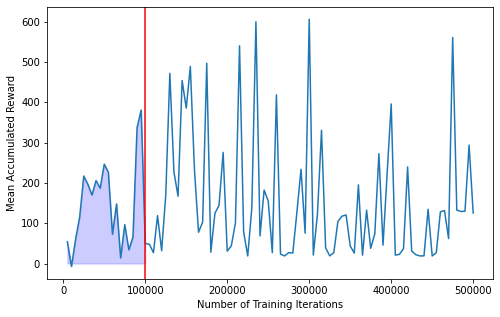

In [4]:
image_name = "ddqn_without_scent_no_buffer_anneal_10000_target_batch_16_learning_curve" #@param {type:"string"}
plt.figure(figsize=(8,5))
iters = np.arange(evaluation_freq, total_timesteps + evaluation_freq, evaluation_freq)
plt.plot(iters, learning_curve)
plt.axvline(x=1e+5, color='red') # So that we can visualize sample efficiency at the same time
plt.fill_between(np.arange(evaluation_freq, 1e+5 + evaluation_freq, evaluation_freq), learning_curve[:int(100000/evaluation_freq)], color="blue", alpha=0.2)
plt.xlabel("Number of Training Iterations")
plt.ylabel("Mean Accumulated Reward")
plt.savefig(f'experiment_plots/{image_name}')

# Sample Efficiency

In [10]:
@dataclass
class Arguments:
  group: str = 'GROUP_011'
  seed: int = 2022
  pretrain: bool = False
  save_weights: bool = False

args = Arguments()

seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
tf.random.set_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

path = './'+args.group+'/'
files = [f for f in listdir(path) if isfile(join(path, f))]
if ('agent.py' not in files) or ('env_info.txt' not in files):
  print("Your GROUP folder does not contain agent.py or env_info.txt!")
  exit()

with open(path+'env_info.txt') as f:
  lines = f.readlines()
env_type = lines[0].lower()

env = get_environment(env_type) 
env_eval = get_environment(env_type)

env.seed(seed)
env_eval.seed(seed)

if 'jellybean' in env_type:
  env_specs = {'scent_space': env.scent_space, 'vision_space': env.vision_space, 'feature_space': env.feature_space, 'action_space': env.action_space}
if 'mujoco' in env_type:
  env_specs = {'observation_space': env.observation_space, 'action_space': env.action_space}
agent_module = importlib.import_module(args.group+'.agent')
agent = agent_module.Agent(env_specs)

# Note: no weights loading
# This is how they evaluate the sample efficiency according to the final project pdf document:
total_timesteps = 1e+5
evaluation_freq = 10000
n_episodes_to_evaluate = 1

sample_efficiency_learning_curve = train_agent(agent, env, env_eval, total_timesteps, evaluation_freq, n_episodes_to_evaluate, args.save_weights)
print(f"Sample Efficiency: {auc(np.arange(total_timesteps / evaluation_freq), sample_efficiency_learning_curve)}")


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/content/project/GROUP_011/agent.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_batch = torch.stack([torch.tensor(a[1]) for a in sample])


timestep: 10000, acc_reward: 195.50
timestep: 20000, acc_reward: 149.30
timestep: 30000, acc_reward: 240.90
timestep: 40000, acc_reward: 528.20
timestep: 50000, acc_reward: 641.30
timestep: 60000, acc_reward: 502.60
timestep: 70000, acc_reward: 711.40
timestep: 80000, acc_reward: 275.50
timestep: 90000, acc_reward: 128.10
timestep: 100000, acc_reward: 751.30
Done
Sample Efficiency: 3650.6999997645617


## WARNING: Run above block 3 times with different seeds and record the learning curves below after each run

In [5]:
lc1 = sample_efficiency_learning_curve

In [8]:
lc2 = sample_efficiency_learning_curve

In [11]:
lc3 = sample_efficiency_learning_curve

In [18]:
avg_learning_curve = np.mean([lc1, lc2, lc3], axis=0)
avg_auc = auc(np.arange(total_timesteps / evaluation_freq), avg_learning_curve)

In [19]:
avg_auc

2234.499999860923

## Plot sample efficiency

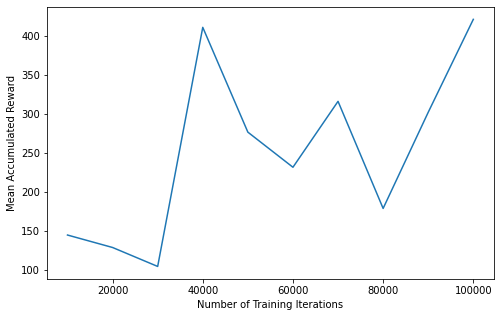

In [20]:
image_name = "ddqn_without_scent_buffer_1000_anneal_10000_target_batch_16_sample_efficiency" #@param {type:"string"}
plt.figure(figsize=(8,5))
iters = np.arange(evaluation_freq, total_timesteps + evaluation_freq, evaluation_freq)
plt.plot(iters, avg_learning_curve)
plt.xlabel("Number of Training Iterations")
plt.ylabel("Mean Accumulated Reward")
plt.savefig(f'experiment_plots/{image_name}')

# Performance
Note: we repeat some boilerplate code because we want to reset the seed, agent, environment, etc.

In [ ]:
@dataclass
class Arguments:
  group: str = 'GROUP_011'
  seed: int = 0
  pretrain: bool = True
  save_weights: bool = False

args = Arguments()

seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
tf.random.set_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

path = './'+args.group+'/'
files = [f for f in listdir(path) if isfile(join(path, f))]
if ('agent.py' not in files) or ('env_info.txt' not in files):
  print("Your GROUP folder does not contain agent.py or env_info.txt!")
  exit()

with open(path+'env_info.txt') as f:
  lines = f.readlines()
env_type = lines[0].lower()

env = get_environment(env_type) 
env_eval = get_environment(env_type)

env.seed(seed)
env_eval.seed(seed)

if 'jellybean' in env_type:
  env_specs = {'scent_space': env.scent_space, 'vision_space': env.vision_space, 'feature_space': env.feature_space, 'action_space': env.action_space}
if 'mujoco' in env_type:
  env_specs = {'observation_space': env.observation_space, 'action_space': env.action_space}
agent_module = importlib.import_module(args.group+'.agent')
agent = agent_module.Agent(env_specs)
if args.pretrain:
  agent.load_weights()

n_episodes_to_evaluate = 1

performance_score = evaluate_agent(agent, env_eval, n_episodes_to_evaluate)
print(f"Performance Score: {performance_score}")


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Performance Score: 769.5999999642372


# Evolution of Q Values

In [ ]:
def evaluate_Q_values(agent, random_states):    
  max_Q_values = []
  for state in random_states:
    max_Q_values.append(agent.max_Q(state))
  return np.mean(max_Q_values)

def train_agent_record_Q(agent,
                env,
                random_states,
                total_timesteps,
                evaluation_freq):

  timestep = 0
  max_Q_values = []  
    
  while timestep < total_timesteps:
    done = False
    curr_obs = env.reset()
    while not done:    
      action = agent.act(curr_obs, mode='train')
      next_obs, reward, done, _ = env.step(action)
      agent.update(curr_obs, action, reward, next_obs, done, timestep)
      curr_obs = next_obs
        
      timestep += 1
      if timestep % evaluation_freq == 0:
        avg_max_Q = evaluate_Q_values(agent, random_states)
        print('timestep: {ts}, average Q: {Q:.2f}'.format(ts=timestep, Q=avg_max_Q))
        max_Q_values.append(avg_max_Q)

  print('Done')
  return max_Q_values

# args
@dataclass
class Arguments:
  group: str = 'GROUP_011'
  seed: int = 0
  pretrain: bool = False
  algorithm: str = 'ddqn' # Choices: ddqn or dqn
  save_weights: bool = False

args = Arguments()

# seed
seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
tf.random.set_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

path = './'+args.group+'/'
files = [f for f in listdir(path) if isfile(join(path, f))]
if ('agent.py' not in files) or ('env_info.txt' not in files):
  print("Your GROUP folder does not contain agent.py or env_info.txt!")
  exit()

with open(path+'env_info.txt') as f:
  lines = f.readlines()
env_type = lines[0].lower()

env = get_environment(env_type)
env.seed(seed)

if 'jellybean' in env_type:
  env_specs = {'scent_space': env.scent_space, 'vision_space': env.vision_space, 'feature_space': env.feature_space, 'action_space': env.action_space}
if 'mujoco' in env_type:
  env_specs = {'observation_space': env.observation_space, 'action_space': env.action_space}
agent_module = importlib.import_module(args.group+'.agent')
agent = agent_module.Agent(env_specs)
if args.pretrain:
  agent.load_weights()

total_timesteps = 1e+5
evaluation_freq = 1000

# Generating a sequence of states from a random policy
rand_policy_env = get_environment(env_type)
rand_policy_env.seed(seed)

done = False
curr_obs = rand_policy_env.reset()
random_states = [curr_obs]
while not done:  
  next_obs, reward, done, _ = rand_policy_env.step(rand_policy_env.action_space.sample())
  random_states.append(next_obs)

max_Q_values = train_agent_record_Q(agent, env, random_states, total_timesteps, evaluation_freq)


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


timestep: 1000, average Q: 0.34


/content/project/GROUP_011/agent.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_batch = torch.stack([torch.tensor(a[1]) for a in sample])


timestep: 2000, average Q: 0.31
timestep: 3000, average Q: 0.31
timestep: 4000, average Q: 0.29
timestep: 5000, average Q: 0.30
timestep: 6000, average Q: 0.33
timestep: 7000, average Q: 0.36
timestep: 8000, average Q: 0.40
timestep: 9000, average Q: 0.50
timestep: 10000, average Q: 0.56
timestep: 11000, average Q: 0.64
timestep: 12000, average Q: 0.69
timestep: 13000, average Q: 0.79
timestep: 14000, average Q: 0.83
timestep: 15000, average Q: 0.88
timestep: 16000, average Q: 0.97
timestep: 17000, average Q: 1.02
timestep: 18000, average Q: 1.07
timestep: 19000, average Q: 1.16
timestep: 20000, average Q: 1.18
timestep: 21000, average Q: 1.26
timestep: 22000, average Q: 1.30
timestep: 23000, average Q: 1.33
timestep: 24000, average Q: 1.39
timestep: 25000, average Q: 1.45
timestep: 26000, average Q: 1.53
timestep: 27000, average Q: 1.57
timestep: 28000, average Q: 1.64
timestep: 29000, average Q: 1.69
timestep: 30000, average Q: 1.73
timestep: 31000, average Q: 1.84
timestep: 32000, a

## Plot the Q Values Curve

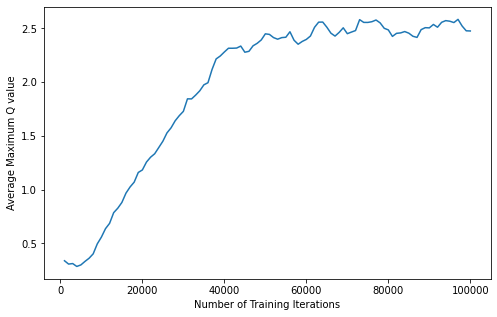

In [ ]:
image_name = "ddqn_without_scent_buffer_cap_1000_anneal_10000_target_batch_16_q_values" #@param {type:"string"}
plt.figure(figsize=(8,5))
iters = np.arange(evaluation_freq, total_timesteps + evaluation_freq, evaluation_freq)
plt.plot(iters, max_Q_values)
plt.xlabel("Number of Training Iterations")
plt.ylabel("Average Maximum Q value")
plt.savefig(f'experiment_plots/{image_name}')